# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1540/1540), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 4393 (delta 1459), reused 1408 (delta 1401), pack-reused 2853 (from 1)
Receiving objects: 100% (4393/4393), 650.73 MiB | 36.99 MiB/s, done.
Resolving deltas: 100% (2661/2661), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [10]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [11]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f1e7e9f0dc0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

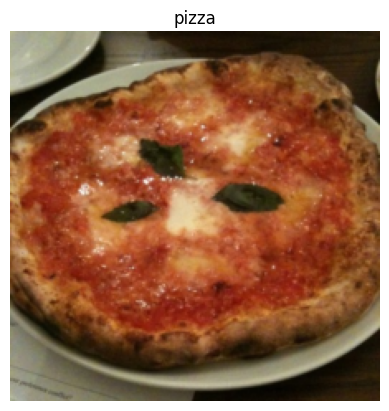

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

### Train Models

#### EffNetB2

In [10]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 61.5MB/s]


In [12]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0092 | train_acc: 0.4875 | test_loss: 0.8100 | test_acc: 0.8943
Epoch: 2 | train_loss: 0.7360 | train_acc: 0.7917 | test_loss: 0.6390 | test_acc: 0.8824
Epoch: 3 | train_loss: 0.5945 | train_acc: 0.8833 | test_loss: 0.5562 | test_acc: 0.8943
Epoch: 4 | train_loss: 0.4623 | train_acc: 0.8979 | test_loss: 0.4991 | test_acc: 0.8818
Epoch: 5 | train_loss: 0.4702 | train_acc: 0.8521 | test_loss: 0.4552 | test_acc: 0.8790
Epoch: 6 | train_loss: 0.4305 | train_acc: 0.8667 | test_loss: 0.4260 | test_acc: 0.9034
Epoch: 7 | train_loss: 0.4251 | train_acc: 0.8750 | test_loss: 0.3921 | test_acc: 0.9034
Epoch: 8 | train_loss: 0.3942 | train_acc: 0.8604 | test_loss: 0.4107 | test_acc: 0.9102
Epoch: 9 | train_loss: 0.3830 | train_acc: 0.8938 | test_loss: 0.3788 | test_acc: 0.8881
Epoch: 10 | train_loss: 0.3760 | train_acc: 0.8542 | test_loss: 0.3473 | test_acc: 0.9193


#### ViT

In [5]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [15]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 123MB/s] 


In [16]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7872 | train_acc: 0.7271 | test_loss: 0.4059 | test_acc: 0.9159
Epoch: 2 | train_loss: 0.3536 | train_acc: 0.9000 | test_loss: 0.2641 | test_acc: 0.9472
Epoch: 3 | train_loss: 0.2728 | train_acc: 0.9083 | test_loss: 0.1959 | test_acc: 0.9688
Epoch: 4 | train_loss: 0.1891 | train_acc: 0.9583 | test_loss: 0.1767 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.1659 | train_acc: 0.9604 | test_loss: 0.1499 | test_acc: 0.9688
Epoch: 6 | train_loss: 0.1637 | train_acc: 0.9646 | test_loss: 0.1358 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.1334 | train_acc: 0.9646 | test_loss: 0.1271 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.1547 | train_acc: 0.9354 | test_loss: 0.1227 | test_acc: 0.9750
Epoch: 9 | train_loss: 0.1305 | train_acc: 0.9688 | test_loss: 0.1145 | test_acc: 0.9750
Epoch: 10 | train_loss: 0.1209 | train_acc: 0.9750 | test_loss: 0.1058 | test_acc: 0.9750


### Make Prediction

In [37]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaries
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label

            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

In [18]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi/test


[PosixPath('data/pizza_steak_sushi/test/pizza/1555015.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/788315.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/998005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2398925.jpg')]

#### CPU - EffNetB2

In [19]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [20]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1555015.jpg'),
  'class_name': 'pizza',
  'pred_prob': 1.0,
  'pred_class': 'pizza',
  'time_for_pred': 0.402,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/788315.jpg'),
  'class_name': 'pizza',
  'pred_prob': 1.0,
  'pred_class': 'sushi',
  'time_for_pred': 0.1397,
  'correct': False}]

In [21]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/pizza/1555015.jpg,pizza,1.0,pizza,0.4020,True
1,data/pizza_steak_sushi/test/pizza/788315.jpg,pizza,1.0,sushi,0.1397,False
2,data/pizza_steak_sushi/test/pizza/998005.jpg,pizza,1.0,sushi,0.1389,False
3,data/pizza_steak_sushi/test/pizza/1687143.jpg,pizza,1.0,pizza,0.1362,True
4,data/pizza_steak_sushi/test/pizza/2398925.jpg,pizza,1.0,sushi,0.1356,False


In [22]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1679 seconds


#### GPU- EffNetB2

In [23]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts_GPU = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cuda") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [24]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_dicts_GPU_df = pd.DataFrame(effnetb2_test_pred_dicts_GPU)
effnetb2_test_pred_dicts_GPU_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/pizza/1555015.jpg,pizza,1.0,pizza,0.1585,True
1,data/pizza_steak_sushi/test/pizza/788315.jpg,pizza,1.0,sushi,0.0330,False
2,data/pizza_steak_sushi/test/pizza/998005.jpg,pizza,1.0,sushi,0.0338,False
3,data/pizza_steak_sushi/test/pizza/1687143.jpg,pizza,1.0,pizza,0.0275,True
4,data/pizza_steak_sushi/test/pizza/2398925.jpg,pizza,1.0,sushi,0.0254,False


In [25]:
# Find the average time per prediction
effnetb2_average_time_per_pred_GPU = round(effnetb2_test_pred_dicts_GPU_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction on GPU: {effnetb2_average_time_per_pred_GPU} seconds")

EffNetB2 average time per prediction on GPU: 0.028 seconds


#### CPU - ViT

In [26]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [27]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/pizza/1555015.jpg,pizza,0.9991,pizza,0.8136,True
1,data/pizza_steak_sushi/test/pizza/788315.jpg,pizza,0.9995,pizza,0.5744,True
2,data/pizza_steak_sushi/test/pizza/998005.jpg,pizza,0.9987,pizza,0.5676,True
3,data/pizza_steak_sushi/test/pizza/1687143.jpg,pizza,0.9995,pizza,0.5700,True
4,data/pizza_steak_sushi/test/pizza/2398925.jpg,pizza,0.9995,pizza,0.5881,True


In [28]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.667 seconds


#### GPU - ViT

In [29]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts_GPU = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cuda")

  0%|          | 0/150 [00:00<?, ?it/s]

In [30]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_dicts_GPU_df = pd.DataFrame(vit_test_pred_dicts_GPU)
vit_test_pred_dicts_GPU_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/pizza/1555015.jpg,pizza,0.9991,pizza,0.1342,True
1,data/pizza_steak_sushi/test/pizza/788315.jpg,pizza,0.9995,pizza,0.0319,True
2,data/pizza_steak_sushi/test/pizza/998005.jpg,pizza,0.9987,pizza,0.0293,True
3,data/pizza_steak_sushi/test/pizza/1687143.jpg,pizza,0.9995,pizza,0.0290,True
4,data/pizza_steak_sushi/test/pizza/2398925.jpg,pizza,0.9995,pizza,0.0289,True


In [31]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred_GPU = round(vit_test_pred_dicts_GPU_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred_GPU} seconds")

ViT average time per prediction: 0.0213 seconds


In [40]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([{'EffNetB2 (CPU)':effnetb2_average_time_per_pred,
                    'EffNetB2 (GPU)':effnetb2_average_time_per_pred_GPU,
                    'ViT (CPU)':vit_average_time_per_pred,
                    'ViT (GPU)':vit_average_time_per_pred_GPU}])

df

,EffNetB2 (CPU),EffNetB2 (GPU),ViT (CPU),ViT (GPU)
0,0.1679,0.028,0.667,0.0213


## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

### Get Data

In [6]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
vit_food101, vit_transforms = create_vit_model(num_classes=101)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 133MB/s] 


In [11]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms,
])

In [12]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=food101_train_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

In [26]:
# Setup directory paths to train and test images
train_dir = data_dir / "train"
test_dir = data_dir / "test"

In [21]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Create 20% Food101 Dataloaders

In [14]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [28]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [16]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### Train ViT

In [20]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
vit_food101_results = engine.train(model=vit_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8532 | train_acc: 0.4279 | test_loss: 2.2420 | test_acc: 0.5767
Epoch: 2 | train_loss: 2.2209 | train_acc: 0.5931 | test_loss: 2.1358 | test_acc: 0.6095
Epoch: 3 | train_loss: 2.0587 | train_acc: 0.6439 | test_loss: 2.0853 | test_acc: 0.6257
Epoch: 4 | train_loss: 1.9557 | train_acc: 0.6810 | test_loss: 2.0478 | test_acc: 0.6409
Epoch: 5 | train_loss: 1.8883 | train_acc: 0.7009 | test_loss: 2.0428 | test_acc: 0.6442


### Inspect Results

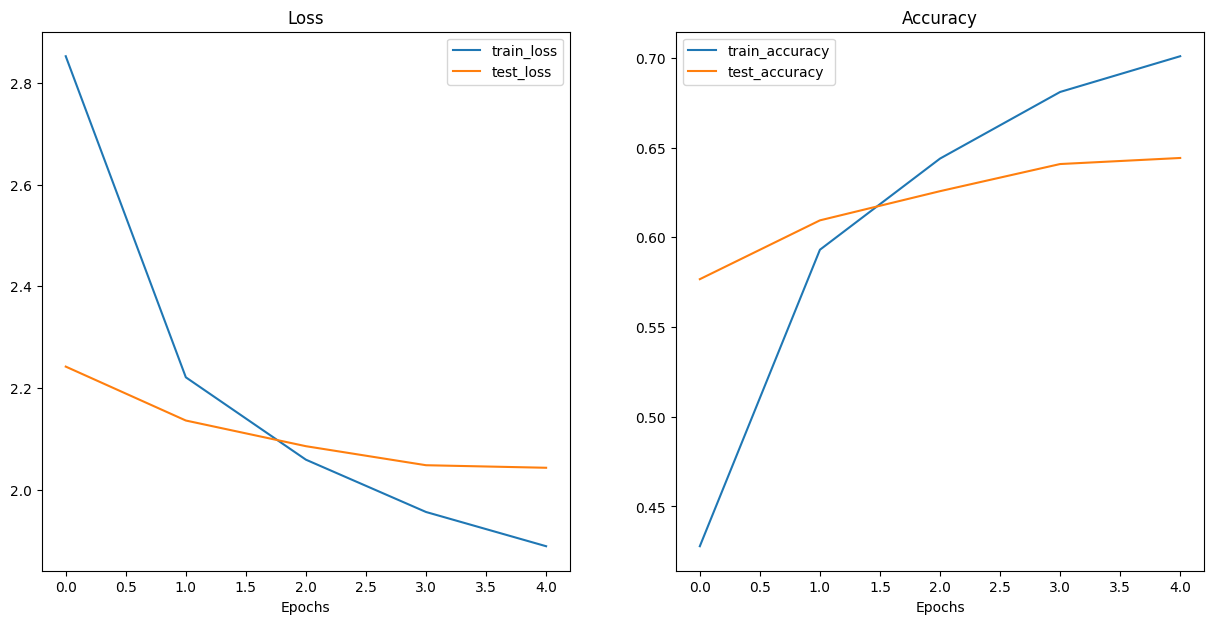

In [22]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(vit_food101_results)

### Save Model

In [23]:
from going_modular.going_modular import utils

# Create a model path
vit_food101_model_path = "09_pretrained_vit_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=vit_food101,
                 target_dir="models",
                 model_name=vit_food101_model_path)

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_food101_20_percent.pth


In [9]:
# Create Food101 compatible EffNetB2 instance
loaded_vit_food101, vit_transforms = create_vit_model(num_classes=101)

# Load the saved model's state_dict()
loaded_vit_food101.load_state_dict(torch.load("models/09_pretrained_vit_feature_extractor_food101_20_percent.pth"))
# model = torch.load("models/09_pretrained_vit_feature_extractor_food101_20_percent.pth", map_location=torch.device("cpu"))
# loaded_vit_food101.load_state_dict(model)

<ipython-input-9-f00a497fe7b6>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_vit_food101.load_state_dict(torch.load("models/09_pretrained_vit_feature_extractor_foo

<All keys matched successfully>

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

### Get Test Samples

In [35]:
from pathlib import Path

# Define the data directory and test.txt path
data_dir = Path("data/food-101")
test_txt_path = data_dir / "meta" / "test.txt"

# Base directory for images
images_dir = data_dir / "images"

# Read the test.txt file and construct full paths
with open(test_txt_path, "r") as file:
    test_data_paths = [images_dir / f"{line.strip()}.jpg" for line in file]

# Example: print the first few paths
print(test_data_paths[:5])

[PosixPath('data/food-101/images/apple_pie/1011328.jpg'), PosixPath('data/food-101/images/apple_pie/101251.jpg'), PosixPath('data/food-101/images/apple_pie/1034399.jpg'), PosixPath('data/food-101/images/apple_pie/103801.jpg'), PosixPath('data/food-101/images/apple_pie/1038694.jpg')]


In [31]:
len(test_data_paths)

25250

### Make Predictions

In [22]:
len(food101_class_names)

101

In [38]:
# Make predictions across test dataset with ViT
vit_food101_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=loaded_vit_food101,
                                          transform=vit_transforms,
                                          class_names=food101_class_names,
                                          device=device)

  0%|          | 0/25250 [00:00<?, ?it/s]

In [44]:
# Turn the vit_food101_test_pred_dicts into a DataFrame
import pandas as pd
vit_food101_test_pred_df = pd.DataFrame(vit_food101_test_pred_dicts)
vit_food101_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/food-101/images/apple_pie/1011328.jpg,apple_pie,0.4042,gyoza,0.0380,False
1,data/food-101/images/apple_pie/101251.jpg,apple_pie,0.1767,apple_pie,0.0294,True
2,data/food-101/images/apple_pie/1034399.jpg,apple_pie,0.1574,deviled_eggs,0.0311,False
3,data/food-101/images/apple_pie/103801.jpg,apple_pie,0.3371,apple_pie,0.0338,True
4,data/food-101/images/apple_pie/1038694.jpg,apple_pie,0.3573,apple_pie,0.0295,True


### Inspect Wrong Labeled Images

In [46]:
# Filter rows where correct is False
filtered_vit_food101_test_pred_df = vit_food101_test_pred_df[vit_food101_test_pred_df["correct"] == False]
filtered_vit_food101_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/food-101/images/apple_pie/1011328.jpg,apple_pie,0.4042,gyoza,0.0380,False
2,data/food-101/images/apple_pie/1034399.jpg,apple_pie,0.1574,deviled_eggs,0.0311,False
5,data/food-101/images/apple_pie/1047447.jpg,apple_pie,0.2753,samosa,0.0304,False
6,data/food-101/images/apple_pie/1068632.jpg,apple_pie,0.1434,hamburger,0.0300,False
8,data/food-101/images/apple_pie/1106961.jpg,apple_pie,0.3445,samosa,0.0302,False


In [53]:
# Sort by pred_prob in descending order
sorted_df = filtered_vit_food101_test_pred_df.sort_values(by="pred_prob", ascending=False)
sorted_df = sorted_df.reset_index(drop=True)
sorted_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/food-101/images/dumplings/970712.jpg,dumplings,0.9835,gyoza,0.0200,False
1,data/food-101/images/ice_cream/2366071.jpg,ice_cream,0.9811,frozen_yogurt,0.0252,False
2,data/food-101/images/mussels/1407674.jpg,mussels,0.9806,oysters,0.0207,False
3,data/food-101/images/omelette/545899.jpg,omelette,0.9804,cheese_plate,0.0244,False
4,data/food-101/images/seaweed_salad/3625701.jpg,seaweed_salad,0.9662,beet_salad,0.0283,False


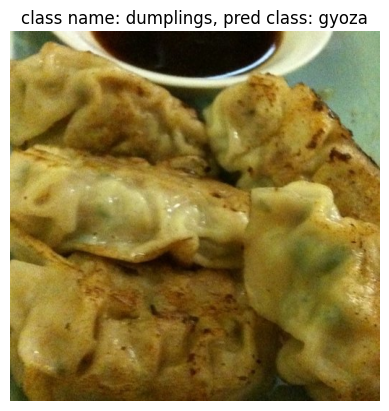

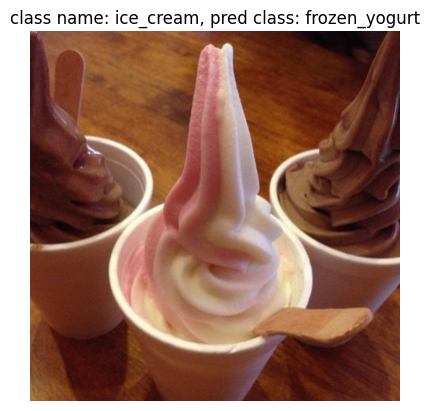

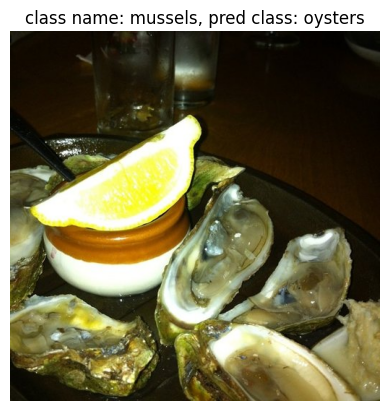

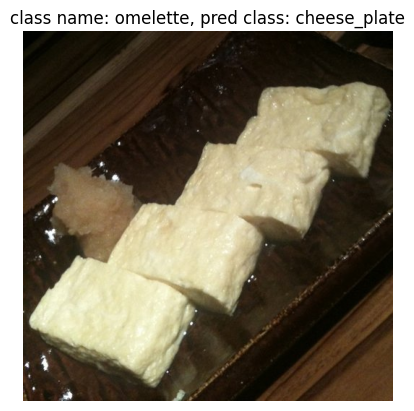

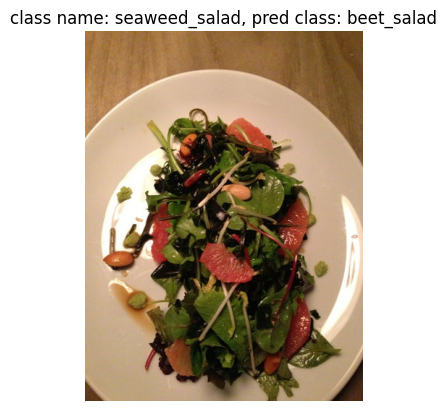

In [59]:
import matplotlib.pyplot as plt
from PIL import Image

# Get the first 5 rows
top_5_wrong = sorted_df.head(5)

# Loop through the rows
for index, row in top_5_wrong.iterrows():
  # Path to the image
  image_path = row['image_path']

  # Open the image
  image = Image.open(image_path)

  plt.imshow(image)
  plt.title(f"class name: {row['class_name']}, pred class: {row['pred_class']}")
  plt.axis('off')  # Remove axis for better visualization
  plt.show()

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

- Did the prediction in Exercise 3, The accuracy has reached 70%

In [40]:
vit_food101_test_pred_dicts[:1]

[{'image_path': PosixPath('data/food-101/images/apple_pie/1011328.jpg'),
  'class_name': 'apple_pie',
  'pred_prob': 0.4042,
  'pred_class': 'gyoza',
  'time_for_pred': 0.038,
  'correct': False}]

In [41]:
# Turn the vit_food101_test_pred_dicts into a DataFrame
import pandas as pd
vit_food101_test_pred_df = pd.DataFrame(vit_food101_test_pred_dicts)
vit_food101_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/food-101/images/apple_pie/1011328.jpg,apple_pie,0.4042,gyoza,0.0380,False
1,data/food-101/images/apple_pie/101251.jpg,apple_pie,0.1767,apple_pie,0.0294,True
2,data/food-101/images/apple_pie/1034399.jpg,apple_pie,0.1574,deviled_eggs,0.0311,False
3,data/food-101/images/apple_pie/103801.jpg,apple_pie,0.3371,apple_pie,0.0338,True
4,data/food-101/images/apple_pie/1038694.jpg,apple_pie,0.3573,apple_pie,0.0295,True


In [42]:
# Check number of correct predictions
vit_food101_test_pred_df.correct.value_counts()

,count
correct,
True,17849
False,7401


In [43]:
# Get the value counts of correct and incorrect predictions
value_counts = vit_food101_test_pred_df.correct.value_counts()

# Extract the counts of correct and incorrect predictions
num_correct = value_counts.get(True, 0)  # Get the count of True values (default 0 if not present)
num_total = value_counts.sum()  # Total number of predictions

# Calculate accuracy
accuracy = num_correct / num_total if num_total > 0 else 0

print(f"Accuracy: {accuracy:.2%}")

Accuracy: 70.69%


## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?
  - Context-aware Attentional Pooling (**CAP**) for Fine-grained Visual Classification
    - focus on finding the difference inside subcatogries, so not just "birds", but what kind of bird within "birds"
    - has these main parts
      - CNN, to extract the feature vector
      - Context Aware attentional pooling, to find how each feature relates to other
      - classification, give the output

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

- Not food images
- More than one type of food in image
- Creative presented food

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

### Get The Model and The Dataset
- The choosen pretrained model is: [ResNet50](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50)
- The choosen dataset is: [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)

In [4]:
from torchvision.models import resnet50, ResNet50_Weights

# Create ResNet50 pretrained weights, transforms and model
resnet50_weights = torchvision.models.ResNet50_Weights.DEFAULT
resnet50_transforms = resnet50_weights.transforms()
resnet50_model = torchvision.models.resnet50(weights=resnet50_weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


In [5]:
from torchinfo import summary

# Print ResNet50 feature extractor model summary
summary(resnet50_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   True
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      4,096                True
│    │    └─BatchN

In [6]:
# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Load training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=resnet50_transforms)
test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=resnet50_transforms)

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [7]:
# Veiw class names
cifar10_class_names = train_dataset.classes
cifar10_class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

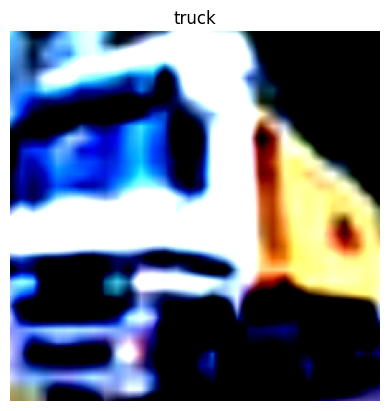

In [8]:
# Plot image with matplotlib
plt.imshow(train_dataset[1][0].permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(cifar10_class_names[train_dataset[1][1]])
plt.axis(False);

In [9]:
import torch

BATCH_SIZE = 32

# Create cifar10 training DataLoader
cifar10_train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True)
# Create cifar10 testing DataLoader
cifar10_test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False)

### Prepare The Model

In [10]:
# Freeze all layers in resnet50 model
for param in resnet50_model.parameters():
    param.requires_grad = False

In [11]:
from torchinfo import summary

# Print ResNet50 feature extractor model summary
summary(resnet50_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   False
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    └─

In [12]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# Change fc head with random seed for reproducibility
set_seeds()
resnet50_model.fc = nn.Linear(
    in_features=2048,
    out_features=len(cifar10_class_names),
    bias=True
)

In [14]:
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
from torchinfo import summary

# Print ResNet50 feature extractor model summary
summary(resnet50_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 10]              --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

### Traing The Model

In [16]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=resnet50_model.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
resnet50_results = engine.train(model=resnet50_model,
                                train_dataloader=cifar10_train_dataloader,
                                test_dataloader=cifar10_test_dataloader,
                                epochs=5,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8208 | train_acc: 0.7364 | test_loss: 0.6182 | test_acc: 0.7908
Epoch: 2 | train_loss: 0.6133 | train_acc: 0.7928 | test_loss: 0.5685 | test_acc: 0.8082
Epoch: 3 | train_loss: 0.5690 | train_acc: 0.8073 | test_loss: 0.5606 | test_acc: 0.8119
Epoch: 4 | train_loss: 0.5430 | train_acc: 0.8139 | test_loss: 0.5410 | test_acc: 0.8150
Epoch: 5 | train_loss: 0.5200 | train_acc: 0.8220 | test_loss: 0.5320 | test_acc: 0.8183


In [24]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=resnet50_model,
                 target_dir="models",
                 model_name="pretrained_resnet50_feature_extractor_cifar10_test_dataloader.pth")

[INFO] Saving model to: models/pretrained_resnet50_feature_extractor_cifar10_test_dataloader.pth


### Inspect The Results

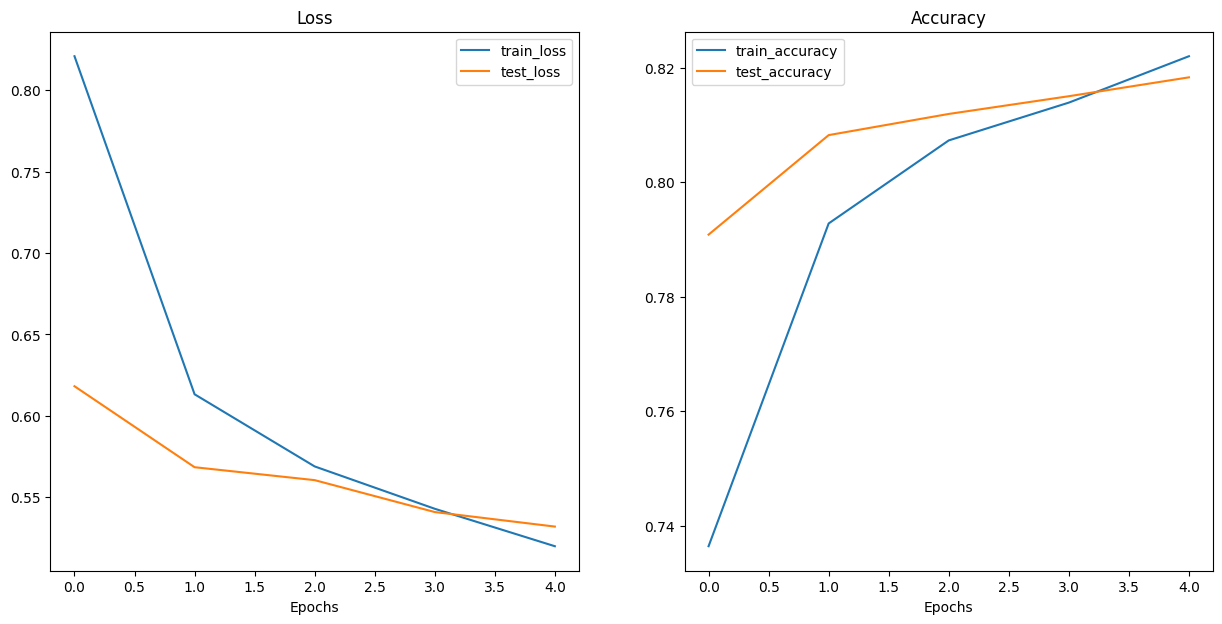

In [25]:
from helper_functions import plot_loss_curves

plot_loss_curves(resnet50_results)

### Create Gradio APP

In [19]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.4 MB/s eta 0:00:00
Gradio version: 5.12.0


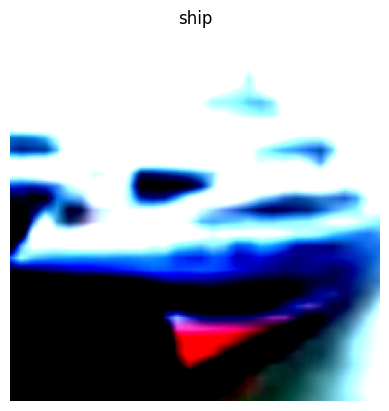

In [20]:
# Plot image with matplotlib
plt.imshow(test_dataset[1][0].permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(cifar10_class_names[test_dataset[1][1]])
plt.axis(False);

In [22]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = resnet50_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    resnet50_model.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(resnet50_model(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {cifar10_class_names[i]: float(pred_probs[0][i]) for i in range(len(cifar10_class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

Prediction label and probability dictionary: 
{'airplane': 0.0, 'automobile': 8.641401252936493e-40, 'bird': 8.547920632381384e-42, 'cat': 0.0, 'deer': 1.943704752704889e-09, 'dog': 1.0, 'frog': 0.0, 'horse': 0.0, 'ship': 0.0, 'truck': 0.0}
Prediction time: 0.01025 seconds


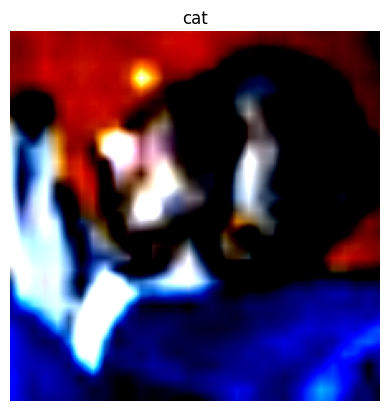

In [32]:
import random
from PIL import Image

# See the image
plt.imshow(test_dataset[0][0].permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(cifar10_class_names[test_dataset[0][1]])
plt.axis(False);


# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=test_dataset[0][0].to(device))
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

In [33]:
from torchvision.transforms import ToPILImage
import os

# Directory to save example images (optional if you want file paths)
example_dir = "examples"
os.makedirs(example_dir, exist_ok=True)

# Convert tensor images to PIL images
to_pil = ToPILImage()

# Create example list
example_list = []

# Select a few examples from the test dataset
for idx in range(5):  # Change the range for more examples
    img, label = test_dataset[idx]  # Get image and label
    pil_img = to_pil(img)  # Convert tensor to PIL image

    # Save to disk (optional)
    example_path = os.path.join(example_dir, f"example_{idx}.png")
    pil_img.save(example_path)

    # Append the file path (Gradio supports file paths for examples)
    example_list.append(example_path)

# Print the example list
print("Example List:", example_list)

Example List: ['examples/example_0.png', 'examples/example_1.png', 'examples/example_2.png', 'examples/example_3.png', 'examples/example_4.png']


In [34]:
import gradio as gr

# Create title, description and article strings
title = "Image Classifier for CIFAR-10 Using ResNet50"
# This application is a fine-tuned ResNet50 model trained on the CIFAR-10 dataset, capable of classifying images into 10 distinct categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
description = "A ResNet50 feature extractor computer vision model trained on the CIFAR-10 dataset, capable of classifying images into 10 distinct categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck."
article = "Built using Gradio and PyTorch"


# Create the Gradio interface
demo = gr.Interface(
    fn=predict,  # Function to call
    inputs=gr.Image(type="pil"),  # Input type (PIL image)
    outputs=[
        gr.Label(num_top_classes=3, label="Predictions"),  # Top 3 predictions
        gr.Number(label="Prediction time (s)")  # Time taken for prediction
    ],
    examples=example_list,  # List of example images
    title=title,
    description=description,
    article=article
)

# Launch the Gradio app
demo.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5dca9b4ccd8a9675b7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2042, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1589, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 8

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5dca9b4ccd8a9675b7.gradio.live
